#### Friday, January 19, 2024

https://github.com/PacktPublishing/Vector-Search-for-Practitioners-with-Elastic/blob/main/chapter3/Chapter_3_Model_Management_and_Vector_Considerations_in_Elastic.ipynb

We get the following error ...

AuthorizationException: AuthorizationException(403, 'security_exception', 'current license is non-compliant for [ml]')

In [ ]:
# !pip -Qu install datasets transformers

# Loading the IMDB dataset

In [1]:
from datasets import load_dataset
imdb_dataset = load_dataset("imdb")

# 1m 13.1s

# Tokenize imdb Dataset

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load a small portion of the IMDB dataset (100 samples)
imdb_dataset = load_dataset("imdb", split="train[:100]")


In [3]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [4]:
# Tokenize the IMDB dataset with truncation and padding
tokenized_imdb_dataset = imdb_dataset.map(
lambda x: tokenizer(x["text"], truncation=True, padding="max_length")
)

In [5]:
print(tokenized_imdb_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})


In [6]:
# Get the first row of tokens
first_row_tokens = tokenized_imdb_dataset[0]["input_ids"]

In [7]:
# Print the first 10 tokens and their corresponding words
for token in first_row_tokens[:10]:
  print(f"Token: {token}, Word: {tokenizer.decode([token])}")

Token: 101, Word: [CLS]
Token: 1045, Word: i
Token: 12524, Word: rented
Token: 1045, Word: i
Token: 2572, Word: am
Token: 8025, Word: curious
Token: 1011, Word: -
Token: 3756, Word: yellow
Token: 2013, Word: from
Token: 2026, Word: my


# Spaces example code
Set up Gradio interface

In [ ]:
#!pip install gradio transformers

In [8]:
import gradio as gr
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

# 4m 8,8s

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [9]:
def sentiment_analysis(text):
    result = sentiment_pipeline(text)
    return result[0]["label"]

In [10]:
iface = gr.Interface(fn=sentiment_analysis, inputs="text", outputs="text")
iface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# Elastic Eland

In [ ]:
# !pip install eland

# TODO ADD INDEX CREATION EXAMPLE

## Connect to Elasticsearch and create sample index

I am not going to use Elastic Cloud, but run it locally ...

In [ ]:
# import getpass
# from datetime import datetime

# es_cloud_id = getpass.getpass('Enter Elastic Cloud ID:  ')
# es_api_key = getpass.getpass('Enter cluster API key:  ')

# es = Elasticsearch(cloud_id=es_cloud_id,
#                    api_key=es_api_key
#                    )
# es.info() # should return cluster info

In [11]:
from elasticsearch import Elasticsearch 

# Password for the 'elastic' user generated by Elasticsearch
# esHost = "https://172.19.0.3:9200"
esHost = "https://172.19.0.2:9200"

ELASTIC_PASSWORD = "1A*JdSMVLz2wOZmplLx8"

path2cert = "/elasticsearch/http_ca.crt"

esClient = Elasticsearch(esHost, ca_certs=path2cert, basic_auth=("elastic", ELASTIC_PASSWORD))

In [12]:
# Nice! It works!
esClient.info()

ObjectApiResponse({'name': '74fc4cf508d8', 'cluster_name': 'docker-cluster', 'cluster_uuid': '3138ncAQQAKAhwWvcDQbHQ', 'version': {'number': '8.11.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '76013fa76dcbf144c886990c6290715f5dc2ae20', 'build_date': '2023-12-05T10:03:47.729926671Z', 'build_snapshot': False, 'lucene_version': '9.8.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [13]:
mapping = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "some_field": {"type": "float"},
            "column_a": {"type": "float"},
            "column_b": {"type": "float"},
            "category": {"type": "keyword"},
            "value": {"type": "float"}
        }
    }
}

In [15]:
# to create the index in the next cell, we first need to delete it if it exists
if esClient.indices.exists(index="sample_eland_index"):
    esClient.indices.delete(index="sample_eland_index")

ObjectApiResponse({'acknowledged': True})

In [16]:
# Create the index ... You can only run this once!
esClient.indices.create(index="sample_eland_index", body=mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'sample_eland_index'})

In [17]:
# Populate the index with a small dataset
documents = [
    {"some_field": 95.0, "column_a": 5.0, "column_b": 10.0, "category": "A", "value": 50.0},
    {"some_field": 150.0, "column_a": 7.0, "column_b": 20.0, "category": "B", "value": 140.0},
    {"some_field": 200.0, "column_a": 8.0, "column_b": 25.0, "category": "A", "value": 200.0},
    {"some_field": 50.0, "column_a": 4.0, "column_b": 12.5, "category": "C", "value": 50.0}
]

In [18]:
for doc in documents:
    esClient.index(index="sample_eland_index", body=doc)

## Eland Examples

In [19]:
import eland as ed

df = ed.DataFrame(es_client=esClient, es_index_pattern="sample_eland_index")
filtered_df = df[df['some_field'] > 100]
filtered_df

,category,column_a,column_b,some_field,value
vV-sIY0B6hyBgckYLjy4,B,7.0,20.0,150.0,140.0
vl-sIY0B6hyBgckYLjy9,A,8.0,25.0,200.0,200.0


In [20]:
average_value = df['some_field'].mean()
average_value

123.75

<Axes: xlabel='category', ylabel='value'>

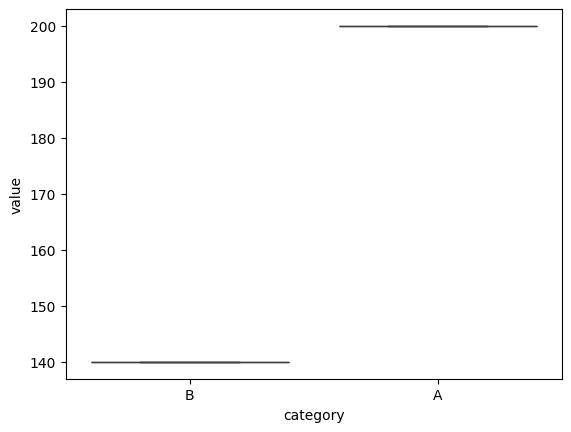

In [21]:
import seaborn as sns
import pandas as pd

filtered_df = df[df['some_field'] > 100]
pandas_df = filtered_df.to_pandas()
sns.boxplot(x='category', y='value', data=pandas_df)

# Loading a Sentence Transformer from Hugging Face into Elasticsearch

In [ ]:
# pip -q install eland elasticsearch transformers sentence_transformers torch==1.13

In [22]:
from pathlib import Path
from eland.ml.pytorch import PyTorchModel
from eland.ml.pytorch.transformers import TransformerModel
from elasticsearch import Elasticsearch
from elasticsearch.client import MlClient

/tmp/ipykernel_88089/1891905041.py:5: DeprecationWarning: Importing from the 'elasticsearch.client' module is deprecated. Instead use 'elasticsearch' module for importing the client.
  from elasticsearch.client import MlClient


Once again, we are not going to use the Elastic Cloud ...

In [ ]:
# import getpass

# es_cloud_id = getpass.getpass('Enter Elastic Cloud ID:  ')
# es_api_key = getpass.getpass('Enter cluster API key:  ')

# es = Elasticsearch(cloud_id=es_cloud_id,
#                    api_key=es_api_key
#                    )
# es.info() # should return cluster info

In [25]:
hf_model_id='sentence-transformers/msmarco-MiniLM-L-12-v3'
# tm = TransformerModel(hf_model_id, "text_embedding")
tm = TransformerModel(model_id=hf_model_id, task_type="text_embedding")

# 3m 53.9s

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/736 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

STAGE:2024-01-19 12:30:07 88089:88089 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-01-19 12:30:07 88089:88089 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-01-19 12:30:07 88089:88089 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [26]:
es_model_id = tm.elasticsearch_model_id()
es_model_id

'sentence-transformers__msmarco-minilm-l-12-v3'

In [27]:
tmp_path = "models"
Path(tmp_path).mkdir(parents=True, exist_ok=True)
model_path, config, vocab_path = tm.save(tmp_path)

In [28]:
ptm = PyTorchModel(esClient, es_model_id)
ptm.import_model(model_path=model_path, config_path=None, vocab_path=vocab_path, config=config)

AuthorizationException: AuthorizationException(403, 'security_exception', 'current license is non-compliant for [ml]')

In [ ]:
# List the in Elasticsearch
m = MlClient.get_trained_models(es, model_id=es_model_id)
m.body

In [ ]:
s = MlClient.start_trained_model_deployment(es, model_id=es_model_id)
s.body

In [ ]:
stats = MlClient.get_trained_models_stats(es, model_id=es_model_id)
stats.body['trained_model_stats'][0]['deployment_stats']['nodes'][0]['routing_state']

In [ ]:
docs =  [
    {
      "text_field": "Last week I upgraded my iOS version and ever since then my phone has been overheating whenever I use your app."
    }
  ]

In [ ]:
z = MlClient.infer_trained_model(es, model_id=es_model_id, docs=docs, )

In [ ]:
doc_0_vector = z['inference_results'][0]['predicted_value']
doc_0_vector

# Reducing Dimensionality

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

In [ ]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [ ]:
# Visualize the original data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Original Iris dataset')
plt.show()

In [ ]:
# Visualize the reduced data
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Iris dataset after PCA')
plt.show()


#Quantization

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer


In [ ]:
# Load the digits dataset
digits = datasets.load_digits()
X = digits.data

# Print the first example from the original dataset
print("Original dataset (first example):\n", X[0])

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X)

# Print the first example after PCA
print("\nReduced dataset after PCA (first example):\n", X_reduced[0])

In [ ]:
# Normalize the reduced vectors to the range [0, 255]
scaler = MinMaxScaler((0, 255))
X_scaled = scaler.fit_transform(X_reduced)

# Print the first example after normalization
print("\nScaled dataset after normalization (first example):\n", X_scaled[0])

In [ ]:
# Quantize the scaled vectors to 8-byte integers
X_quantized = np.round(X_scaled).astype(np.uint8)

# Print the first example after quantization
print("\nQuantized dataset (first example):\n", X_quantized[0])